# Libraries

In [28]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math

#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================================================================== #
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

# Data

In [29]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")

Tenemos 25 columnas y 396 filas


In [30]:
df.drop(['mes_x', 'ano_x','mes_y', 'ano_y'], axis=1, inplace=True)

In [31]:
df.columns = ['fecha','volumenMetro', 'tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'presMax', 'presMin', 'tmedStd', 'precStd',
       'tminStd', 'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd', 'festividad']

In [32]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,volumenMetro,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin,tmedStd,precStd,tminStd,tmaxStd,dirStd,velmediaStd,rachaStd,presMaxStd,presMinStd,festividad
fecha,,,,,,,,,,,,,,,,,,,,
1987-01-01,68.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-02-01,68.782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-03-01,73.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-04-01,64.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-05-01,70.526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df = df.query("fecha < '01-01-2020'")

In [34]:
# Verificar que un índice temporal está completo
# ==============================================================================
(df.index == pd.date_range(
                    start = df.index.min(),
                    end   = df.index.max(),
                    freq  = df.index.freq)
).all()

#https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html

True

# EDA

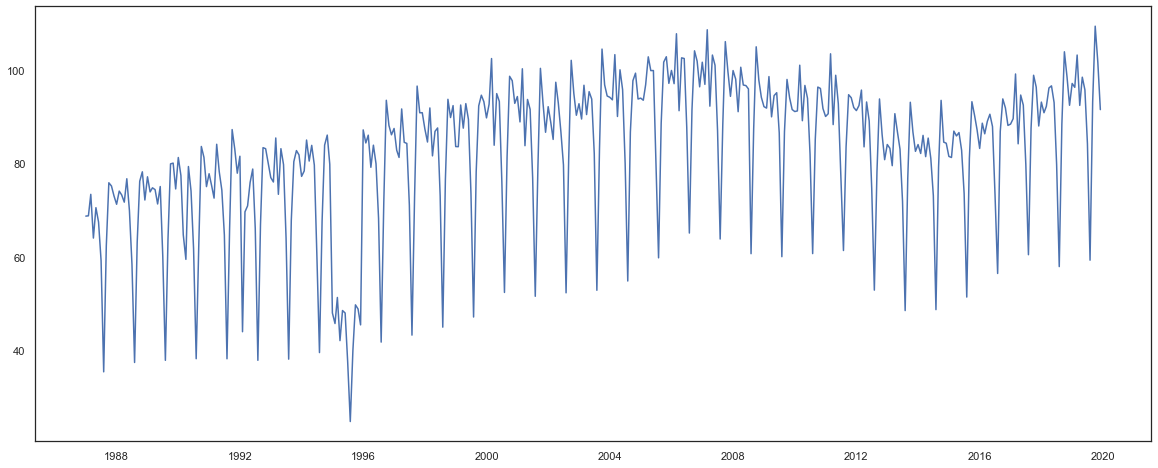

In [35]:
fig, ax1 = plt.subplots(1,1,figsize=(20,8))
ax1.plot(df.volumenMetro)
fig.show()

In [36]:
mean = df.volumenMetro.mean()
sd = df.volumenMetro.std()

Vemos como hay datos en la presion que son NULL podemos imputarlos estimando estos valores para la serie en esos casos. Además, vemos como la mayoría de series son estarionarias, por lo que debemos tratarlo como tal. Vamos a ir comparando de 2 en 2 con la objetivo para ver si existe algún patron.

In [37]:
cols = ['tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia',
       'racha', 'presMax', 'presMin', 'tmedStd', 'precStd', 'tminStd',
       'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd', 'festividad']

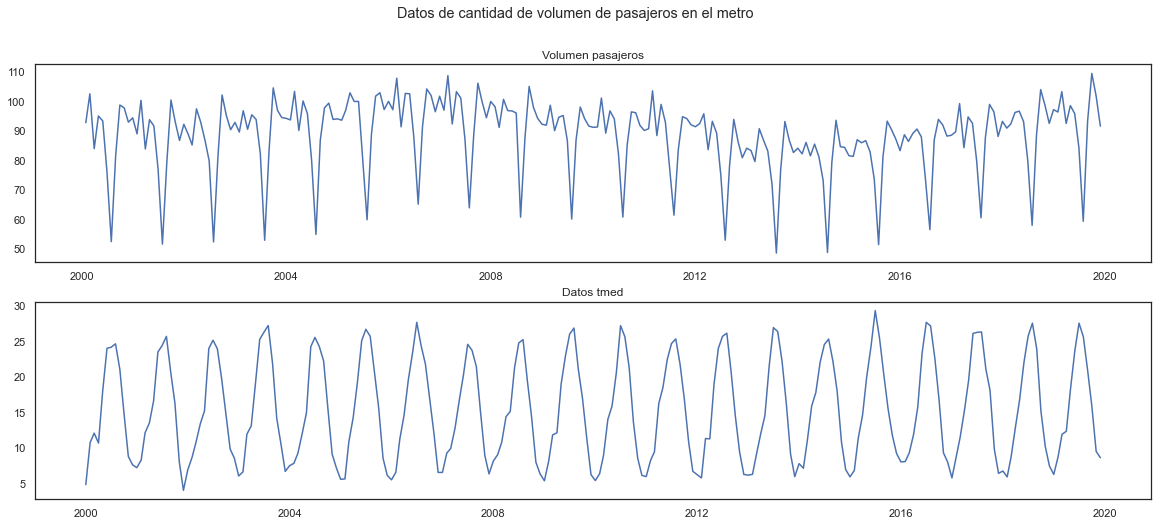

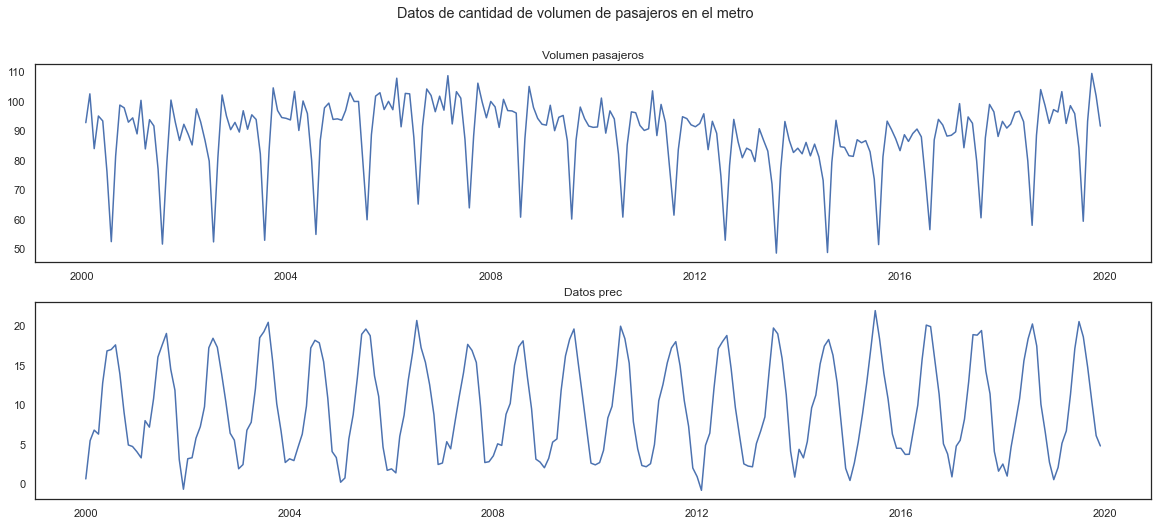

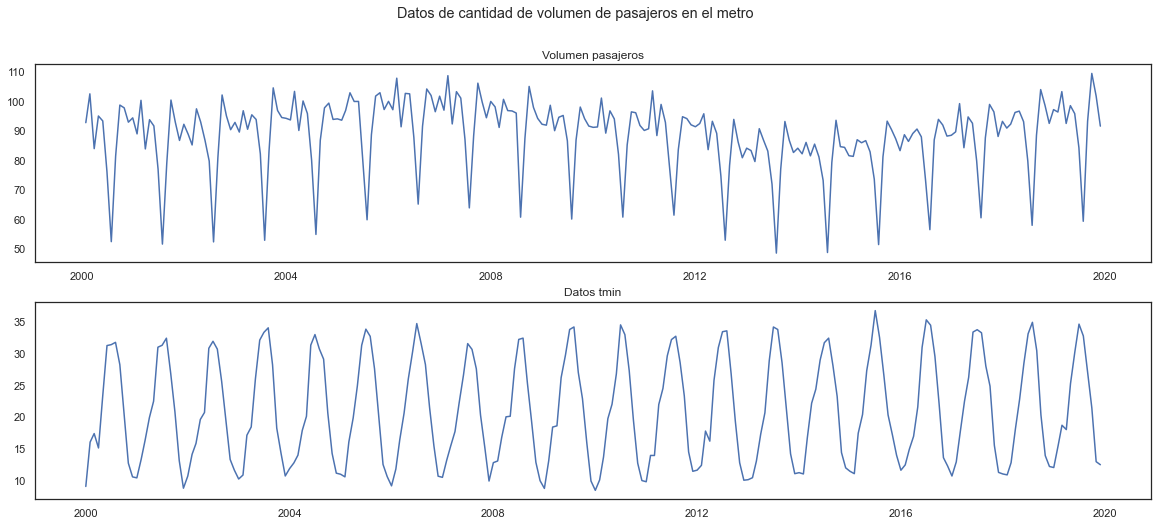

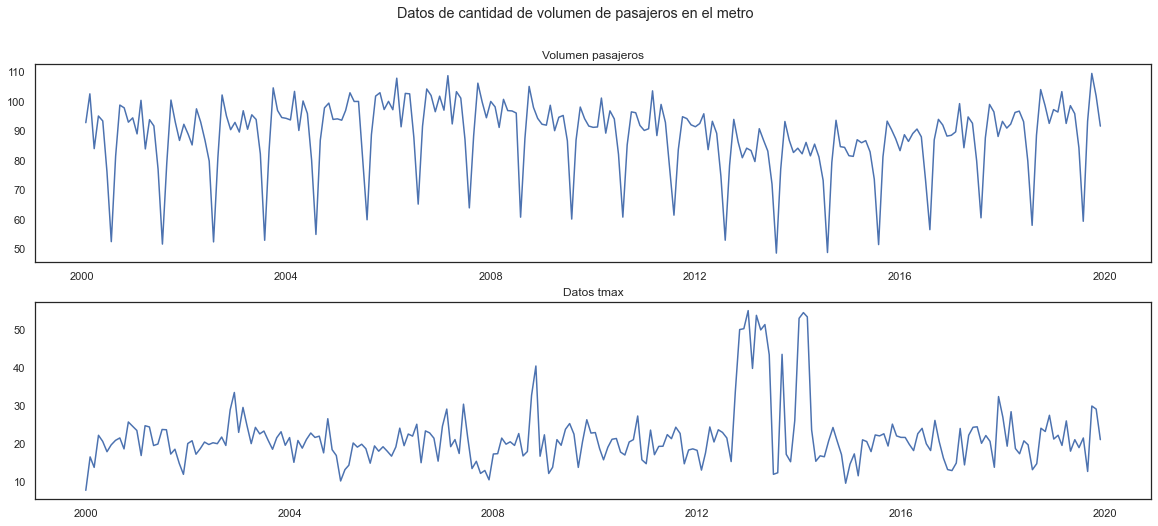

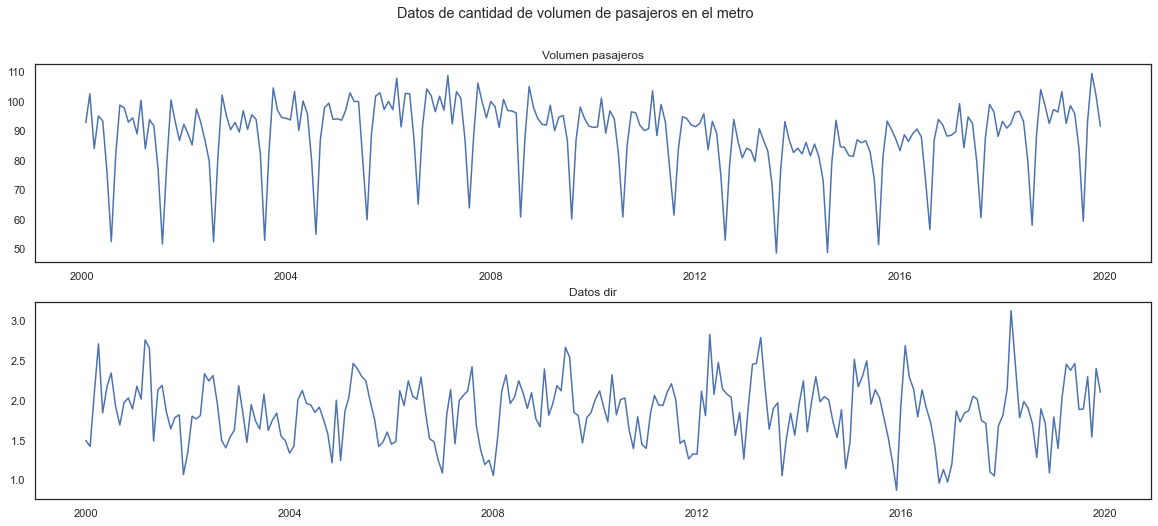

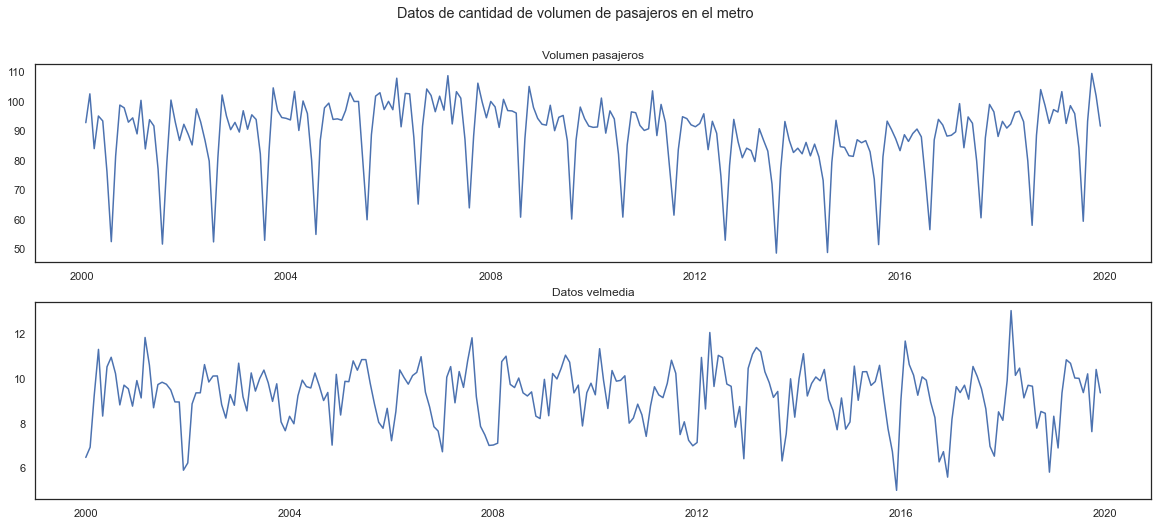

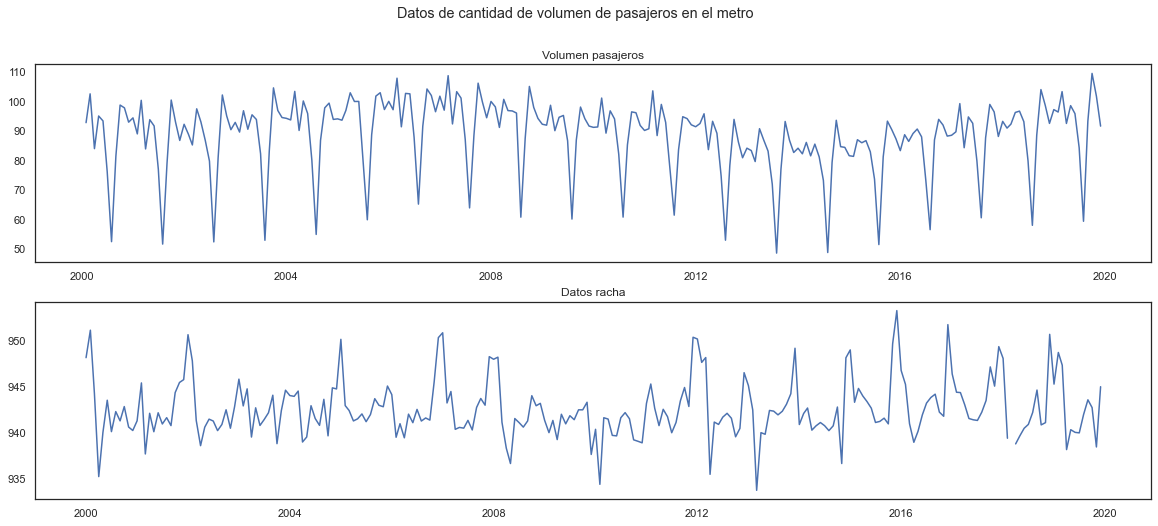

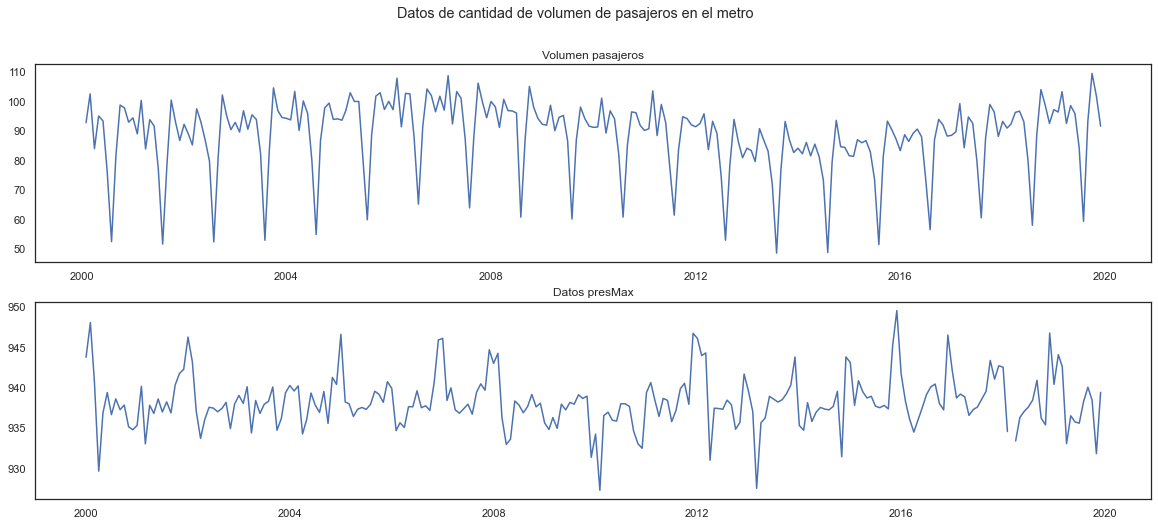

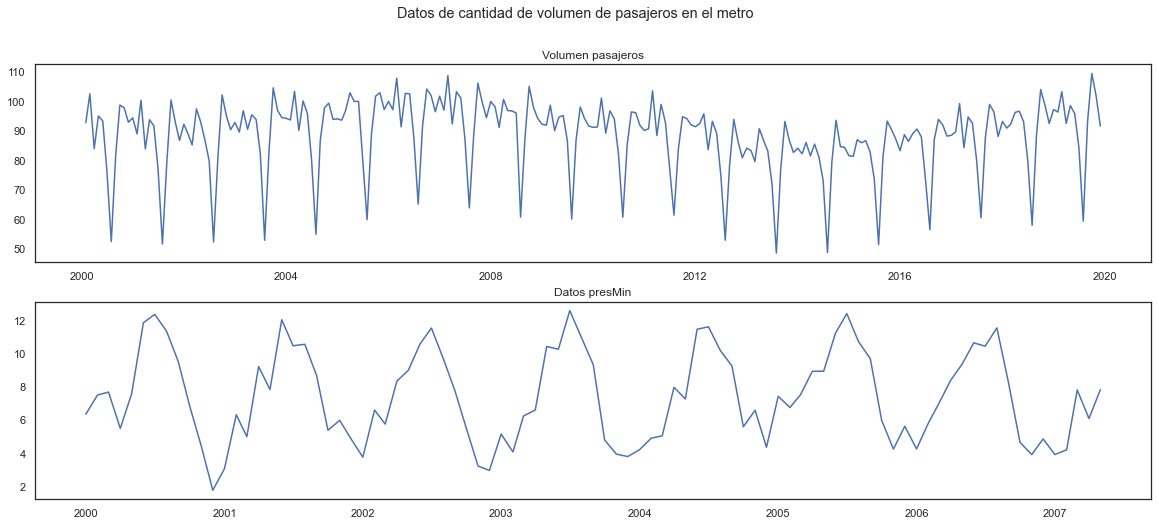

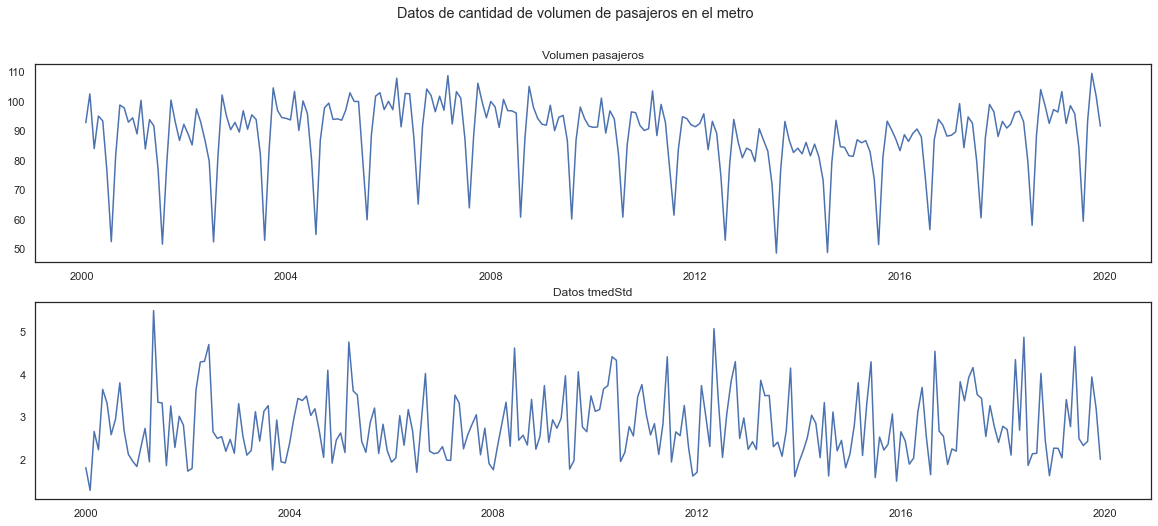

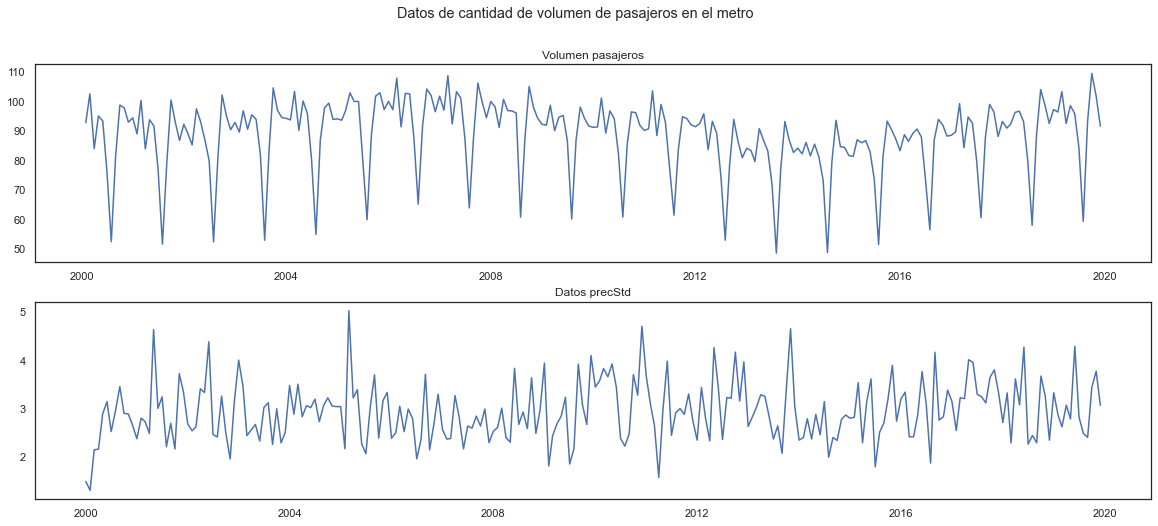

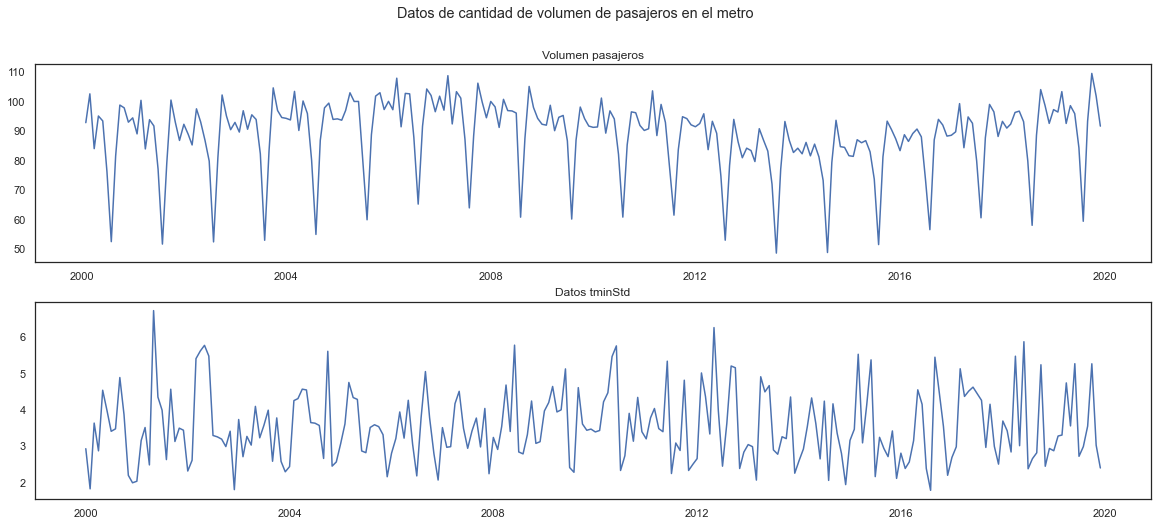

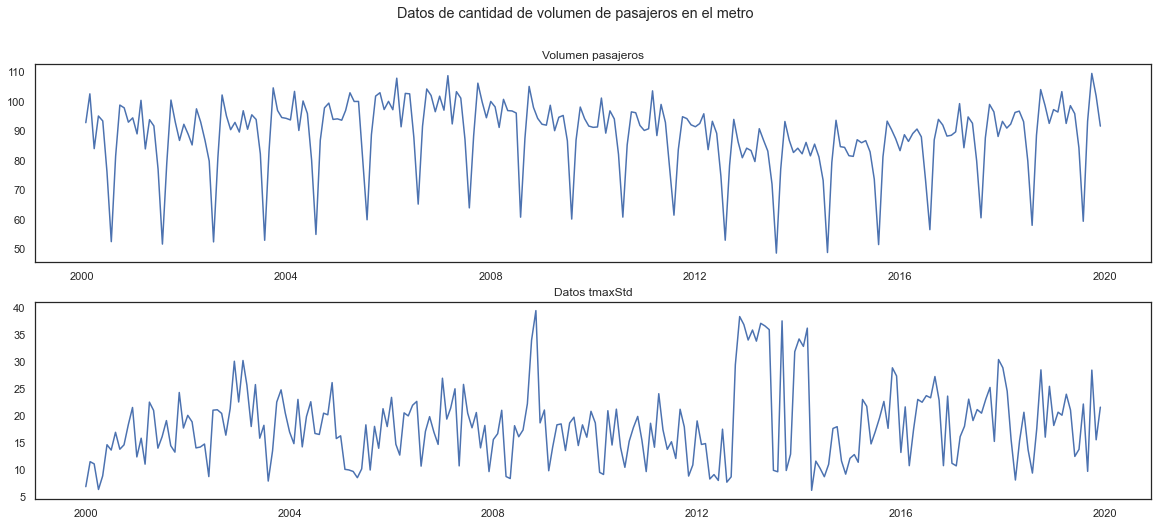

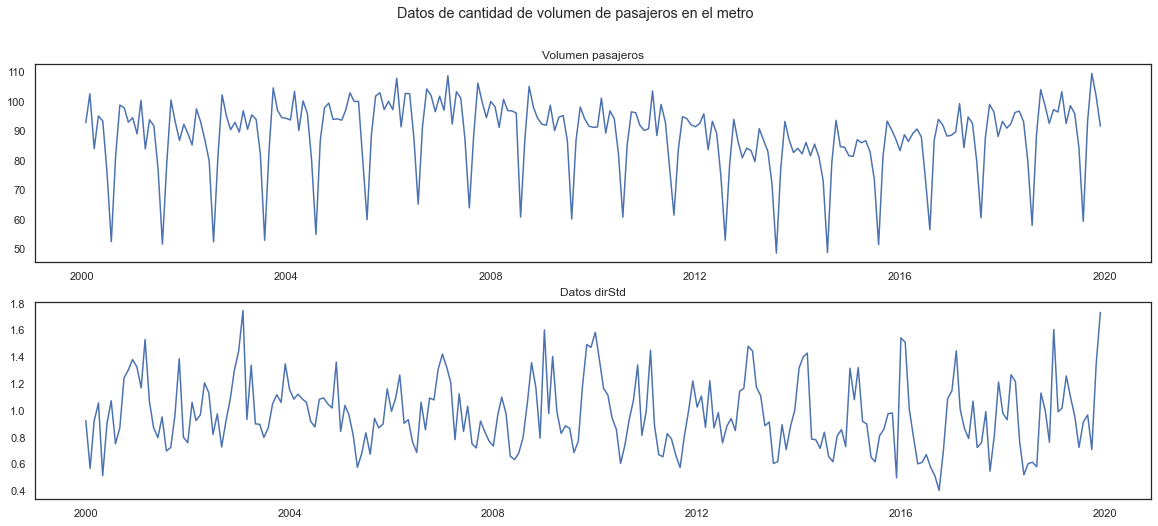

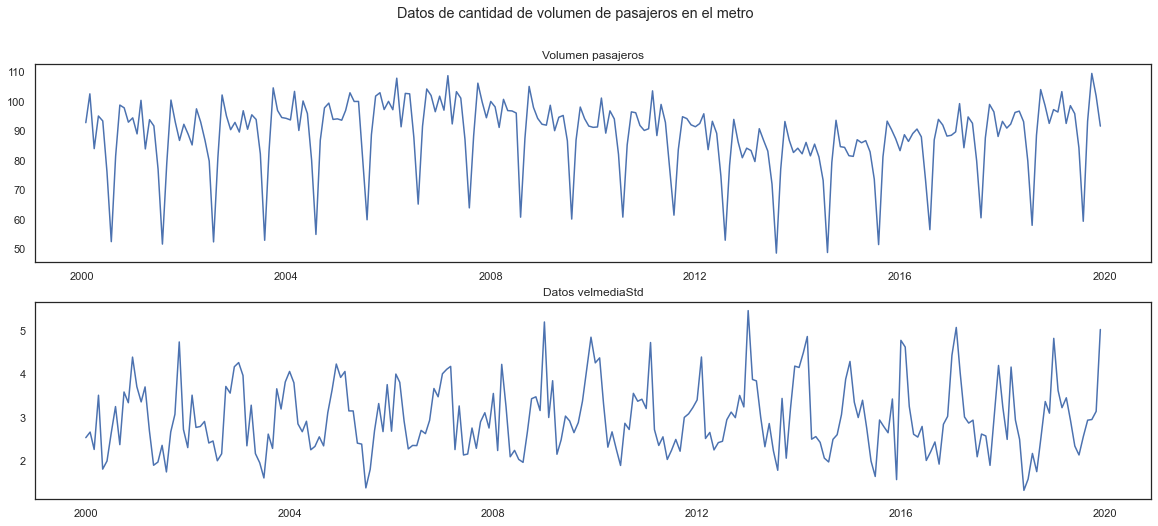

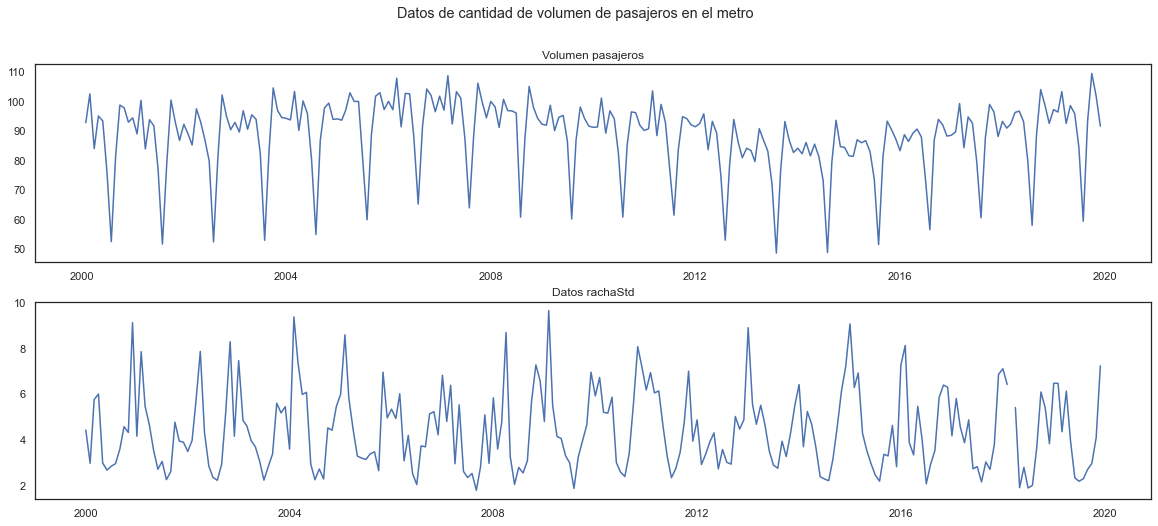

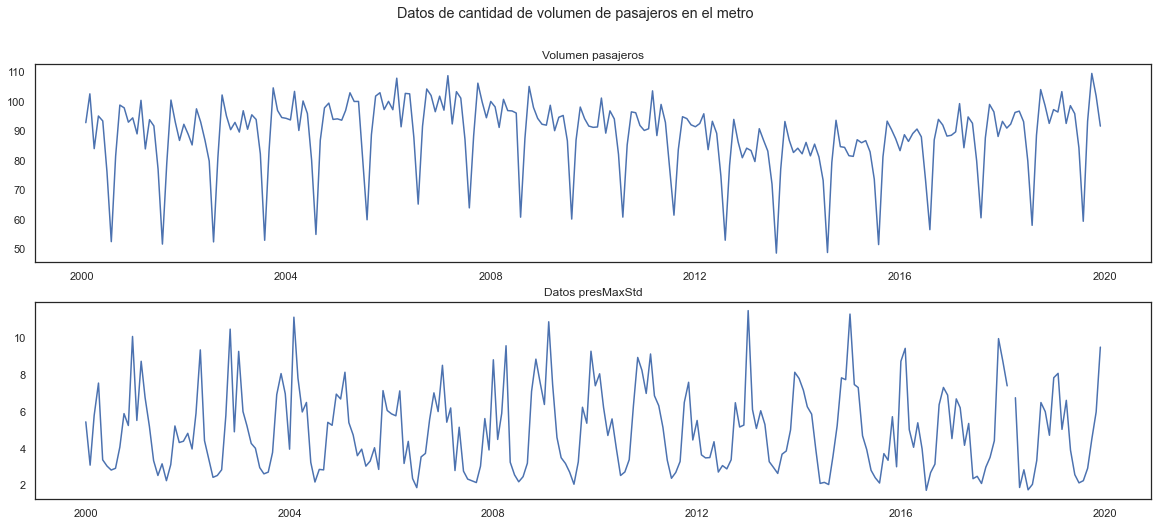

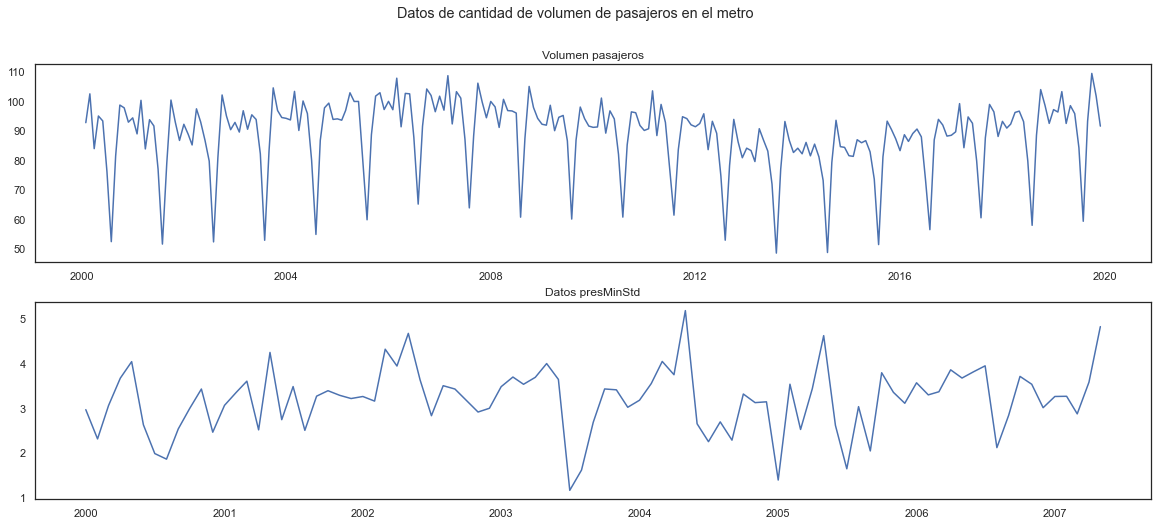

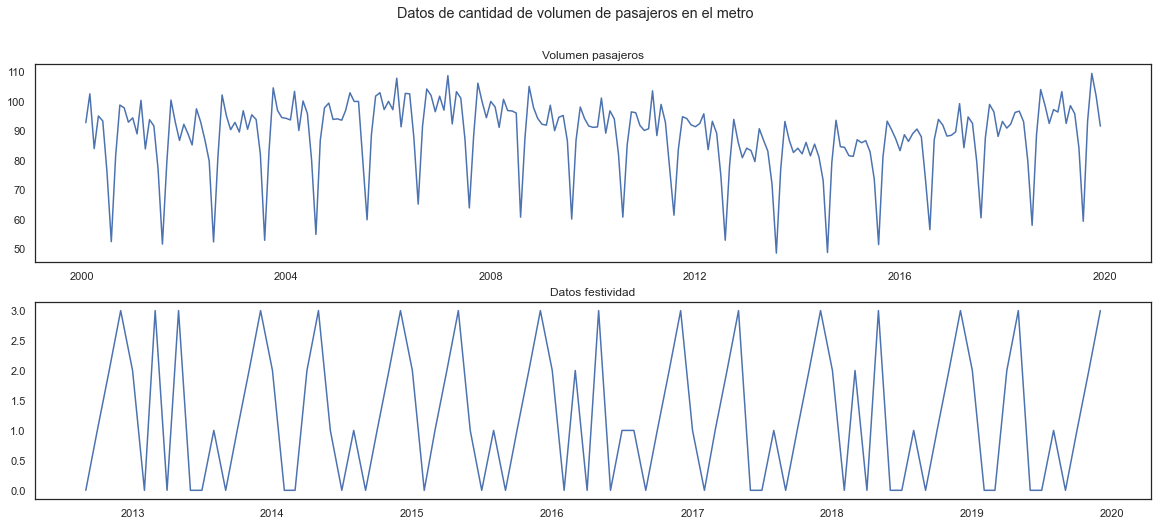

In [42]:
for col in cols:
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,8))
    fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
    ax1.plot(df.query("fecha > '01-01-2000'").volumenMetro)
    ax1.set_title('Volumen pasajeros')
    ax2.plot(df[col])
    ax2.set_title(f"Datos {col}")
    fig.show()

Vemos que la relacion lineal más fuerte es con la temperatura. Y entre el resto de variables si existen correlaciones

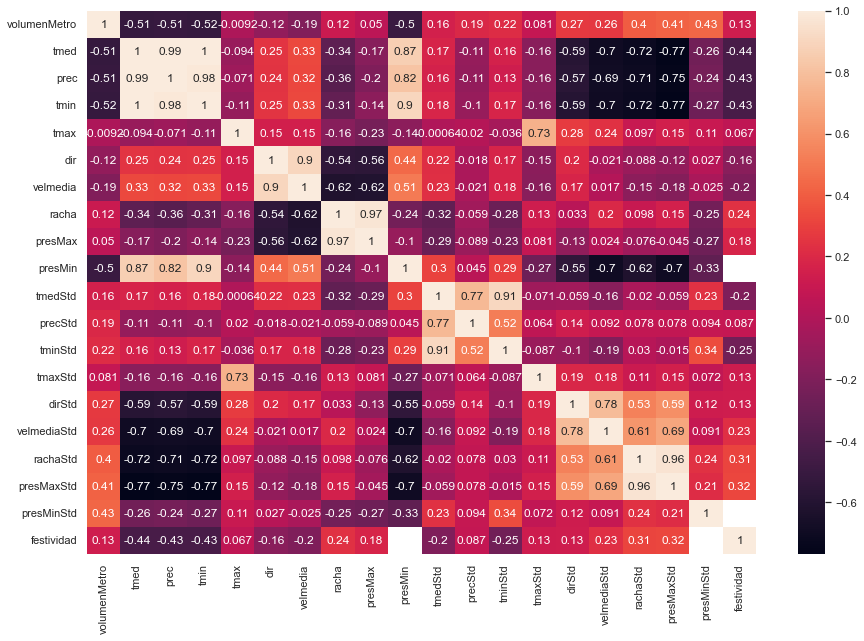

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [40]:
resultV=seasonal_decompose(df['volumenMetro'], model='multiplicable')
resultT=seasonal_decompose(df['tmed'], model='multiplicable')

ValueError: This function does not handle missing values

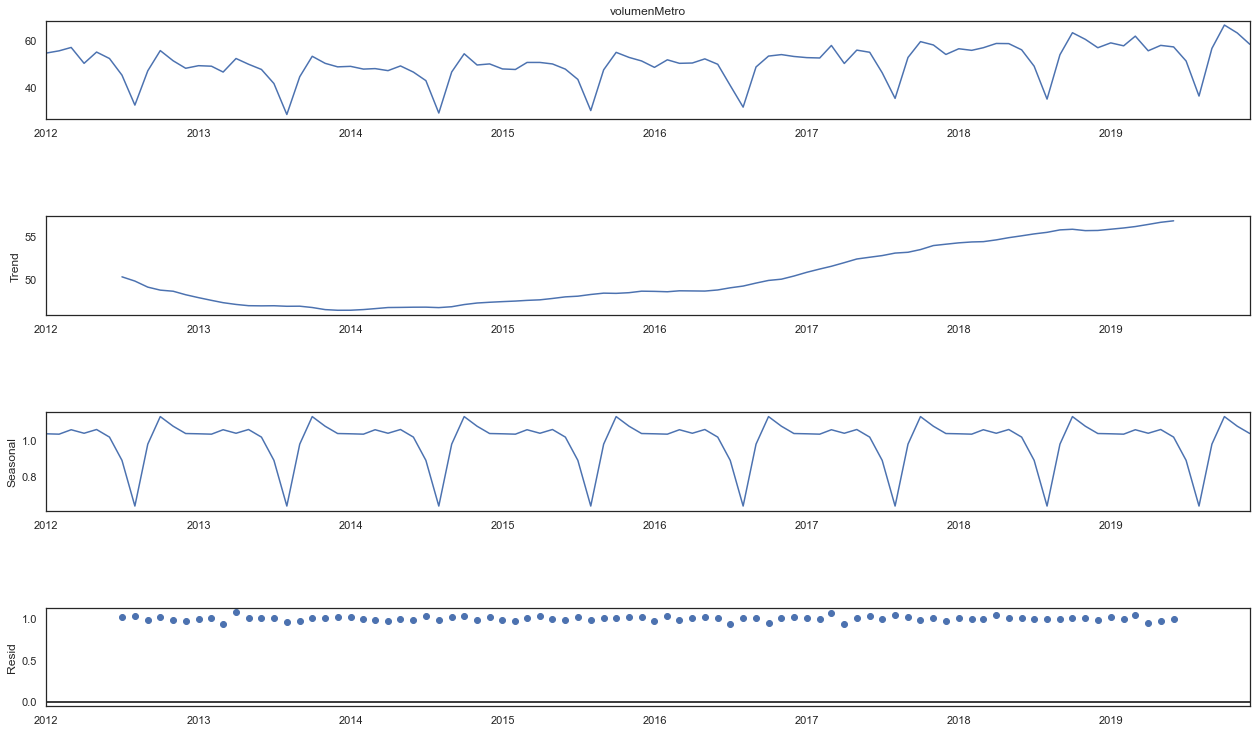

In [ ]:
fig = resultV.plot()
fig.set_size_inches(20, 12)
fig.show()

In [ ]:
print('Componente estacional de volumen pasajeros')
result.seasonal.to_frame().head(12).T

Componente estacional de volumen pasajeros


fecha,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01
seasonal,1.036304,1.034309,1.058745,1.039305,1.059988,1.018021,0.88958,0.637283,0.9792,1.131332,1.078101,1.037834


In [ ]:
print('Componente estacional de la temperatura')
resultT.seasonal.to_frame().head(12).T

Componente estacional de la temperatura


fecha,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,2012-11-01,2012-12-01
seasonal,0.430982,0.477266,0.669018,0.871325,1.12099,1.481441,1.706934,1.688466,1.397033,1.045762,0.646221,0.464564


Vemos como la componente estacional marca que el mes con más pasajeros es octubre y claramente el mes con menos pasajeros es agosto. Si